## Setup and Imports

1. Installing packages
2. Importing libraries

In [35]:
%pip install nlp
%pip install matplotlib
%pip install tensorflow
%pip install datasets
%pip install tf-keras

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
from datasets import load_dataset

%matplotlib inline

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.19.0


## Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [37]:
dataset = load_dataset('emotion')

In [38]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [39]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [40]:
def get_tweet(data):
    tweets = [x['text'] for x in data]
    lTemp = [x['label'] for x in data]
    labels = []
    for l in lTemp:
        if l == 0:
            labels.append("sadness")
        elif l == 1:
            labels.append("joy")
        elif l == 2:
            labels.append('love')
        elif l == 3:
            labels.append('anger')
        elif l == 4:
            labels.append("fear")
        elif l == 5:
            labels.append("surprise")
    return tweets, labels


In [41]:
tweets, labels = get_tweet(train)

In [42]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Tokenizer

1. Tokenizing the tweets

In [43]:
from tf_keras.preprocessing.text import Tokenizer

In [44]:
tokenizer = Tokenizer(num_words = 10000, oov_token = "<UNK>")
tokenizer.fit_on_texts(tweets)

In [45]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [46]:
tweets[0]

'i didnt feel humiliated'

### Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

(array([  8.,  45., 310., 488., 539., 625., 626., 629., 613., 636., 654.,
        655., 608., 622., 609., 603., 559., 535., 530., 510., 452., 430.,
        382., 385., 330., 327., 336., 317., 238., 208., 200., 200., 167.,
        157., 141., 144., 120., 117., 117.,  88.,  96.,  72.,  66.,  66.,
         65.,  52.,  37.,  43.,  30.,  32.,  31.,  26.,  30.,  20.,  23.,
         14.,   9.,  10.,   4.,   4.,   4.,   1.,   4.,   1.]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.,
        41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53.,
        54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66.]),
 <BarContainer object of 64 artists>)

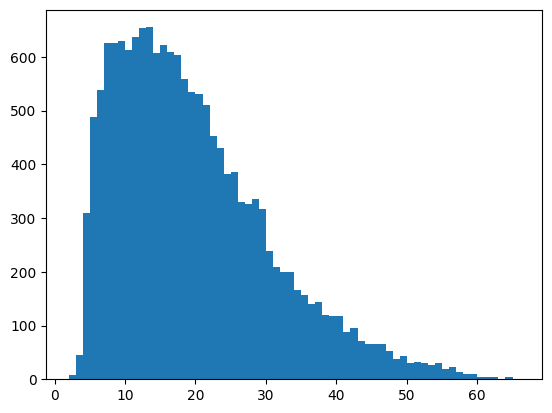

In [47]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))

In [48]:
maxlen = 50

from tf_keras.preprocessing.sequence import pad_sequences

def get_sequences (tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
    return padded

In [49]:
padded_train_seq = get_sequences(tokenizer, tweets)
len(train)

16000

In [50]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

### Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [51]:
classes = set(labels)
print(classes)

{'sadness', 'surprise', 'joy', 'fear', 'love', 'anger'}


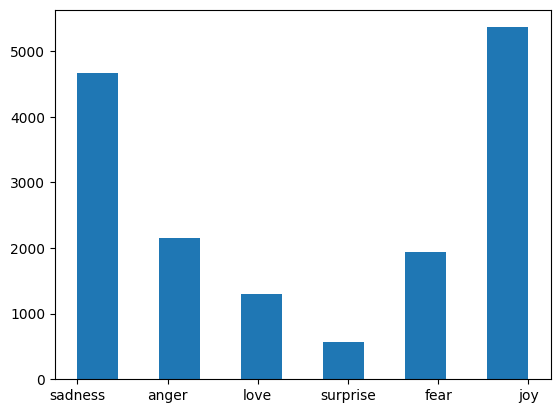

In [52]:
plt.hist(labels, bins=11)
plt.show()

In [53]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k, v in class_to_index.items())

In [54]:
class_to_index

{'sadness': 0, 'surprise': 1, 'joy': 2, 'fear': 3, 'love': 4, 'anger': 5}

In [55]:
index_to_class

{0: 'sadness', 1: 'surprise', 2: 'joy', 3: 'fear', 4: 'love', 5: 'anger'}

In [56]:
names_to_ids =lambda labels: np.array([class_to_index.get(x) for x in labels])

In [57]:
train_labels = names_to_ids(labels)
train_labels = [x.item() for x in train_labels]
len(labels)
#(train_labels[0])

16000

### Creating the Model

1. Creating the model
2. Compiling the model

In [58]:
from tf_keras.models import Sequential
from tf_keras.layers import Embedding, Bidirectional, LSTM, Dense

model = Sequential([Embedding(10000, 16, input_length=maxlen), 
                    Bidirectional(LSTM(20, return_sequences=True)), 
                    Bidirectional(LSTM(20)), 
                    Dense(6, activation='softmax')])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 50, 40)            5920      
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175926 (687.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training the Model

1. Preparing a validation set
2. Training the model

In [60]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)
val_labels = [x.item() for x in val_labels]

In [61]:
val_tweets[0], val_labels[0]
len(train_labels)

16000

In [62]:
from tf_keras.callbacks import EarlyStopping
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

h = model.fit(padded_train_seq, train_labels,
              validation_data=(val_seq, val_labels),
              epochs=100,
              callbacks = [EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/100
500/500 [==============================] - 5s 8ms/step - loss: 1.2663 - accuracy: 0.5054 - val_loss: 0.7622 - val_accuracy: 0.7175
Epoch 2/100
500/500 [==============================] - 3s 7ms/step - loss: 0.5817 - accuracy: 0.7674 - val_loss: 0.6744 - val_accuracy: 0.7660
Epoch 3/100
500/500 [==============================] - 3s 7ms/step - loss: 0.3991 - accuracy: 0.8576 - val_loss: 0.5176 - val_accuracy: 0.8335
Epoch 4/100
500/500 [==============================] - 3s 7ms/step - loss: 0.2615 - accuracy: 0.9139 - val_loss: 0.4371 - val_accuracy: 0.8630
Epoch 5/100
500/500 [==============================] - 3s 7ms/step - loss: 0.1861 - accuracy: 0.9422 - val_loss: 0.4149 - val_accuracy: 0.8710
Epoch 6/100
500/500 [==============================] - 3s 7ms/step - loss: 0.1478 - accuracy: 0.9550 - val_loss: 0.4084 - val_accuracy: 0.8730
Epoch 7/100
500/500 [==============================] - 3s 7ms/step - loss: 0.1149 - accuracy: 0.9647 - val_loss: 0.4069 - val_accuracy: 0.8825

## Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

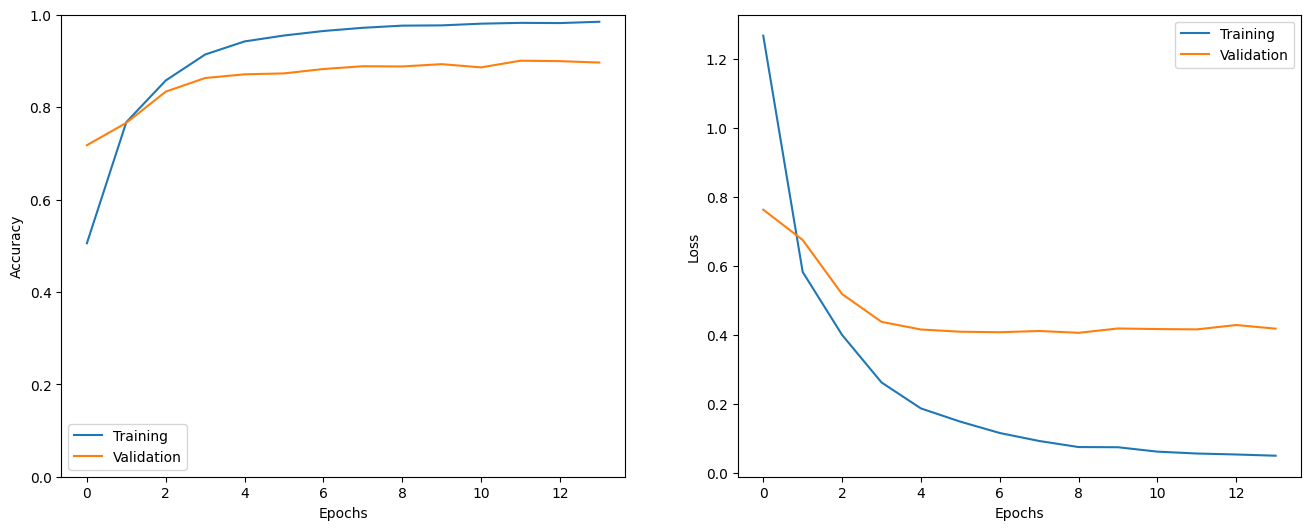

In [63]:
show_history(h)

In [67]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)
test_seq

array([[ 17,   8, 203, ...,   0,   0,   0],
       [ 17,   1,  11, ...,   0,   0,   0],
       [  2, 145,  80, ...,   0,   0,   0],
       ...,
       [  2,   3,   9, ...,   0,   0,   0],
       [ 17,   8,  38, ...,   0,   0,   0],
       [  2,   3,  36, ...,   0,   0,   0]], dtype=int32)

In [68]:
test_results= model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 2ms/step - loss: 0.4469 - accuracy: 0.8810
